# Predicting mean concentrations in the workplace using chemical properties
#### By: Jeff Minucci

### Load required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
%matplotlib inline

### Load the dataset of osha mean concentrations detected at work

In [107]:
osha = pd.read_csv('data/osha/osha_mean_peak.csv')
osha = osha[osha.columns[1:]]
osha = osha.drop(columns=['casrn', 'dtxsid', 'inchikey', 'iupac_name'])
osha = osha.dropna(axis=0)
toxprint_cols = [col for col in osha.columns if ':' in col]
osha[toxprint_cols] = osha[toxprint_cols].astype(int)

### Look at distribution of mean workplace exposure

In [80]:
osha['conc_mgm3'].describe()

count    7.180000e+02
mean     1.921481e+05
std      1.449376e+06
min      0.000000e+00
25%      0.000000e+00
50%      3.598186e+00
75%      6.963074e+03
max      1.954403e+07
Name: conc_mgm3, dtype: float64

(array([707.,   5.,   1.,   0.,   0.,   0.,   0.,   2.,   1.,   2.]),
 array([       0.        ,  1954402.7198364 ,  3908805.4396728 ,
         5863208.1595092 ,  7817610.8793456 ,  9772013.599182  ,
        11726416.3190184 , 13680819.03885481, 15635221.75869121,
        17589624.47852761, 19544027.19836401]),
 <a list of 10 Patch objects>)

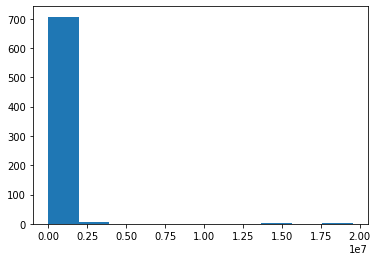

In [81]:
plt.hist(osha['conc_mgm3'])

The high outliers are up at 10 kg/m3, so they must be errors in the data. Let's drop everything above 10,000 mg/mg3

(array([475.,  19.,  12.,   8.,  11.,   7.,   6.,  10.,   4.,   6.]),
 array([   0.        ,  998.74879194, 1997.49758389, 2996.24637583,
        3994.99516778, 4993.74395972, 5992.49275167, 6991.24154361,
        7989.99033556, 8988.7391275 , 9987.48791945]),
 <a list of 10 Patch objects>)

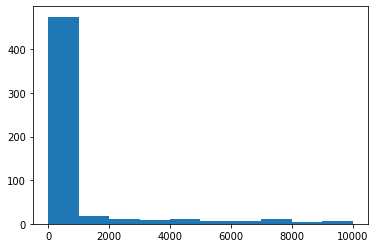

In [108]:
osha = osha.drop(osha[osha['conc_mgm3']>10000].index)
plt.hist(osha['conc_mgm3'])

In [109]:
# It looks like log transforming our response is a good idea
osha['ln_conc_mgm3'] = np.log(osha['conc_mgm3']+0.000001)

# Let's also make a dataset without the mean 0 concentration substances
osha_nonzero = osha[osha['conc_mgm3']>0]


(array([196.,   4.,   2.,   9.,  36.,  85.,  51.,  46.,  46.,  83.]),
 array([-1.38155106e+01, -1.15130507e+01, -9.21059077e+00, -6.90813088e+00,
        -4.60567098e+00, -2.30321109e+00, -7.51194822e-04,  2.30170870e+00,
         4.60416859e+00,  6.90662849e+00,  9.20908838e+00]),
 <a list of 10 Patch objects>)

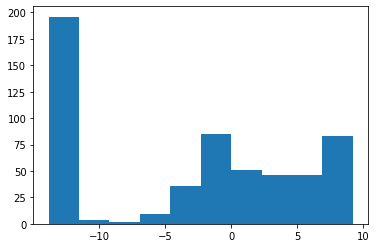

In [110]:
plt.hist(osha['ln_conc_mgm3'])

(array([ 1.,  5.,  3.,  9., 45., 79., 49., 45., 46., 81.]),
 array([-13.32845515, -11.0747008 ,  -8.82094645,  -6.56719209,
         -4.31343774,  -2.05968339,   0.19407097,   2.44782532,
          4.70157967,   6.95533403,   9.20908838]),
 <a list of 10 Patch objects>)

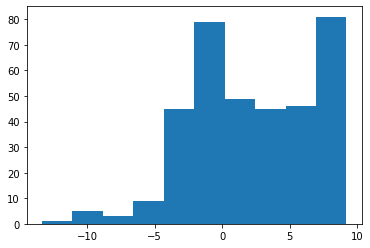

In [111]:
plt.hist(osha_nonzero['ln_conc_mgm3'])

### Let's filter out features that never occur in our chemical dataset 

In [112]:
from sklearn.feature_selection import VarianceThreshold
osha = osha.loc[:, (osha ).any(axis=0)].copy()

### Let's split this into a test and training dataset

In [113]:
y = osha.ln_conc_mgm3
x = osha.drop(['ln_conc_mgm3','conc_mgm3', 'preferred_name'],axis=1)
x_train_all,x_test_all,y_train_all,y_test_all=train_test_split(x,y,test_size=0.2, random_state = 234)


# a version of the dataset with only non-zero concentration substances
y_nz = osha_nonzero.ln_conc_mgm3
x_nz = osha_nonzero.drop(['ln_conc_mgm3','conc_mgm3', 'preferred_name'],axis=1)
x_train_nz,x_test_nz,y_train_nz,y_test_nz=train_test_split(x_nz,y_nz,test_size=0.2, random_state = 234)

# filter out low variance features, but keep full features as x_f for comparison
from sklearn.feature_selection import VarianceThreshold
var_filter = VarianceThreshold(threshold=0.1)
var_filter.fit(x)
x_f = x.loc[:,var_filter.get_support()]
x_train,x_test,y_train,y_test=train_test_split(x_f,y,test_size=0.2, random_state=234)

# same as above but non-zero substances
var_filter = VarianceThreshold(threshold=0.1)
var_filter.fit(x_nz)
x_nzf = x_nz.loc[:,var_filter.get_support()]
x_train_nzf,x_test_nzf,y_train_nzf,y_test_nzf=train_test_split(x_nzf,y_nz,test_size=0.2, random_state=234)

feature_list = list(x_f.columns)
feature_list_all = list(x.columns)
feature_list_nz = list(x_nz.columns)
feature_list_nzf = list(x_nzf.columns)

In [114]:
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (446, 21)
Training Labels Shape: (446,)
Testing Features Shape: (112, 21)
Testing Labels Shape: (112,)


In [118]:
print('Non-zero training, features Shape:', x_train_nz.shape)
print('Non-zero training, reduced features Shape:', x_train_nzf.shape)

Non-zero training, features Shape: (290, 742)
Non-zero training, reduced features Shape: (290, 24)


### Let's try a quick and dirty random forest for a baseline

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

View out-of-bag errors vs number of trees

In [192]:
def plot_rf_oob(x_training, y_training, max_estimators, steps=100):
    r2 = []
    for i in range(0, max_estimators + steps, steps):
        if i == 0:
            i = 100
        rf = RandomForestRegressor(i,random_state=342, oob_score=True)
        rf.fit(x_training, y_training);
        oob = rf.oob_score_
        r2.append((i, oob))
    xs, ys = zip(*r2)
    plt.plot(xs, ys)

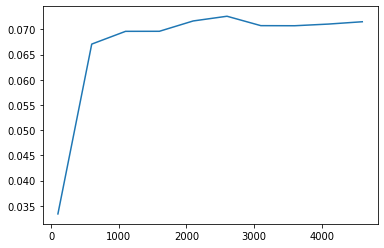

In [150]:
plot_rf_oob(x_train_all, y_train_all,5000, 500)

In [129]:
rf = RandomForestRegressor(1500,random_state=342)
rf.fit(x_train_all, y_train_all);

View the feature importance

In [130]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = feature_list,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(20)

,importance
monoisotopic_mass,0.084041
melting_point_degc_opera_pred,0.077148
biodegradation_half_life_days_days_opera_pred,0.065329
bioconcentration_factor_opera_pred,0.064229
octanol_air_partition_coeff_logkoa_opera_pred,0.054722
vapor_pressure_mmhg_opera_pred,0.050597
opera_km_days_opera_pred,0.049804
water_solubility_mol/l_opera_pred,0.048404
boiling_point_degc_opera_pred,0.047732
soil_adsorption_coefficient_koc_l/kg_opera_pred,0.044537


In [153]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test_all)# Calculate the absolute errors
errors = abs(predictions - y_test_all)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'ln mg/m3.')
print('R2:', r2_score(y_test_all,predictions))

Mean Absolute Error: 3.93 ln mg/m3.
R2: 0.164825905364001


In [132]:
def plot_fit(predicted, y):
    fig, ax = plt.subplots()
    ax.scatter(y, predicted)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured ln mg/m3')
    ax.set_ylabel('Predicted ln mg/m3')
    plt.show()

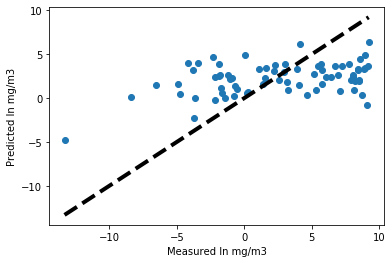

In [154]:
plot_fit(predictions, y_test_all)

### Let's look at using lasso regression

In [163]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(0.0001, 10000000000.0)

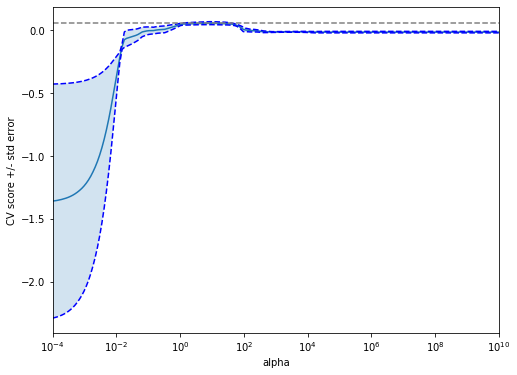

In [155]:
lasso = Lasso(random_state=0, max_iter=100000)
alphas = np.logspace(-4, 10, 200)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, scoring='r2')
clf.fit(x_train, y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)


# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [156]:
clf.best_params_

{'alpha': 8.406652885618316}

In [176]:
lassocv = LassoCV(cv=5,random_state=9).fit(x_train, y_train)
lassocv.score(x_train, y_train)

0.09292582112773085

In [184]:
lassocv.score(x_test, y_test)

-0.9355162253312517

In [172]:
lassocv.alpha_

19.094514412773115

In [179]:
[(feature_list[i], coef) for i, coef in enumerate(lassocv.coef_) if (~np.isclose(coef,0))]

[('bioconcentration_factor_opera_pred', 0.0005336234652479647),
 ('boiling_point_degc_opera_pred', -0.0007357418142726295),
 ('melting_point_degc_opera_pred', -0.0010831582084453854),
 ('monoisotopic_mass', -0.008200273637573512),
 ('soil_adsorption_coefficient_koc_l/kg_opera_pred', 8.481696414510131e-06),
 ('vapor_pressure_mmhg_opera_pred', -0.0002606083038472521)]

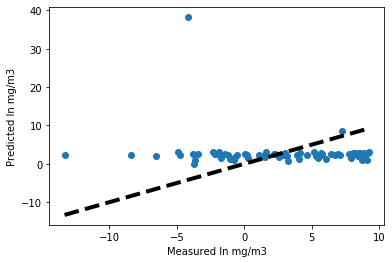

In [180]:
predictions = lassocv.predict(x_test)
plot_fit(predictions, y_test)

### Compare to a lasso model on all features

In [181]:
lassocv2 = LassoCV(cv=5,random_state=0).fit(x_train_all, y_train_all)
lassocv2.score(x_train_all, y_train_all)

0.09292582112773085

In [182]:
lassocv2.score(x_test_all, y_test_all)

-0.9355162253312517

#### When we use all features, we get the same result from the lasso regression

## What if we model only chemicals that had an average peak conc above 0?

### Trying a random forest again

In [34]:
#rf = RandomForestRegressor(2000,random_state=342)
#rf.fit(x_train_nz, y_train_nz);

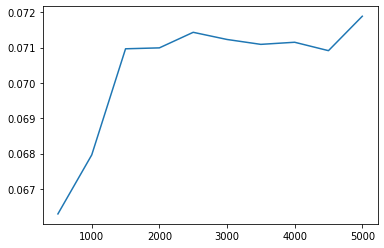

In [193]:
plot_rf_oob(x_train_nz, y_train_nz, 5000,1000)

In [198]:
param_grid = {'n_estimators': [1000, 2000, 2500, 3500, 5000]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=20)
grid_rf.fit(x_train_nz, y_train_nz)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=20,
             param_grid={'n_estimators': [1000, 2000, 2500

In [199]:
grid_rf.best_params_

{'n_estimators': 5000}

In [200]:
best_rf = grid_rf.best_estimator_
predictions = best_rf.predict(x_test_nz)# Calculate the absolute errors
errors = abs(predictions - y_test_nz)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'ln mg/m3.')
print('R2:', r2_score(y_test_nz,predictions))

Mean Absolute Error: 3.95 ln mg/m3.
R2: 0.15778690927757322


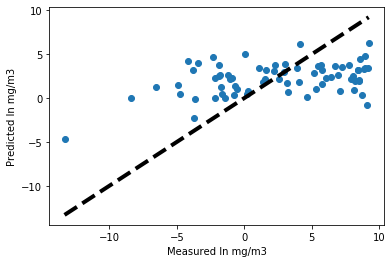

In [201]:
plot_fit(predictions, y_test_nz)

### Let's try a multi-layer perceptron for fun

In [202]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train_nz)
StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_scaled = scaler.transform(x_train_nz)
x_test_scaled = scaler.transform(x_test_nz)

In [227]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(activation='relu',hidden_layer_sizes=(400, 400, 200),max_iter=10000, learning_rate='adaptive', verbose=True)
mlp.fit(x_train_scaled,y_train_nz)

Iteration 1, loss = 11.49529221
Iteration 2, loss = 9.70399061
Iteration 3, loss = 8.04189369
Iteration 4, loss = 6.89418574
Iteration 5, loss = 5.84596726
Iteration 6, loss = 4.92680644
Iteration 7, loss = 4.53116226
Iteration 8, loss = 3.84804432
Iteration 9, loss = 3.39717259
Iteration 10, loss = 2.89035424
Iteration 11, loss = 2.61376590
Iteration 12, loss = 2.32773719
Iteration 13, loss = 2.05038954
Iteration 14, loss = 1.85778127
Iteration 15, loss = 1.66649714
Iteration 16, loss = 1.50545996
Iteration 17, loss = 1.32362834
Iteration 18, loss = 1.28114509
Iteration 19, loss = 1.13121418
Iteration 20, loss = 1.08463941
Iteration 21, loss = 0.95054987
Iteration 22, loss = 0.86259091
Iteration 23, loss = 0.81424779
Iteration 24, loss = 0.74628202
Iteration 25, loss = 0.73357460
Iteration 26, loss = 0.66346857
Iteration 27, loss = 0.62151378
Iteration 28, loss = 0.60012724
Iteration 29, loss = 0.54942719
Iteration 30, loss = 0.54043668
Iteration 31, loss = 0.55264234
Iteration 32, lo

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(400, 400, 200), learning_rate='adaptive',
             learning_rate_init=0.001, max_iter=10000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [228]:
mlp.score(x_test_scaled,y_test_nz) # r2

0.0947271796279834

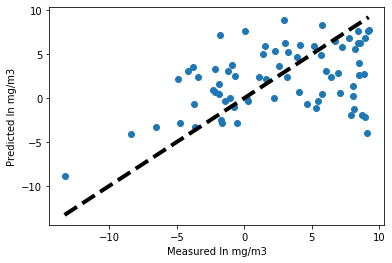

In [229]:
predictions = mlp.predict(x_test_scaled)
plot_fit(predictions,y_test_nz)